<a href="https://colab.research.google.com/github/flaghunter21/DFS/blob/main/Contest_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Draftkings MLB Contest Analysis

In this project, we will be importing a raw Draftkings CSV file and player information to analyze the tendencies of the player population. The sample Draftkings CSV file is from the `$15 MLB $125K RELAY THROW [$25K TO 1ST]` contest. The player information was imported from FantasyCruncher's `Lineup Rewind` feature.

## Read in Data

The data was consolidated to one excel file with a `standings` sheet containing the results of the contest, and a `players` sheet containing the player information.

In [313]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
contest = pd.read_excel('colab_contest_analyzer.xlsx', sheet_name='standings').dropna()
contest.head()

,Rank,EntryId,EntryName,TimeRemaining,Points,Lineup
0,1,3257533438,ihbrown3 (22/150),0,213.05,P Jordan Montgomery P Kyle Freeland OF Aaron J...
1,2,3257373692,BRORANNOSAURUS_FLEX (77/150),0,209.20,P Michael Lorenzen P Jordan Montgomery OF Shoh...
2,3,3257533499,ihbrown3 (83/150),0,198.05,P Jordan Montgomery P Kyle Freeland OF Aaron J...
3,4,3257484992,pianoclub (30/70),0,197.15,P Jordan Montgomery OF Aaron Judge OF Mike Tro...
4,5,3257062564,giantsquid (38/150),0,194.20,P Michael Lorenzen P Jordan Montgomery OF Shoh...


The contest file contains the following columns:
* `Rank` - A user's final ranking in the contest
* `EntryID` - Unique EntryID for each entry in the contest
* `EntryName` - Name of user
* `TimeRemaining` - Innings remaining in the lineup
* `Points` - Total points scored by the lineup
* `Lineup` - Each player and respective position in the lineup

In [314]:
players = pd.read_excel('colab_contest_analyzer.xlsx', sheet_name='players')
players.head()

,Player,Inj,Likes,Pos,Salary,Order,Hand,Team,Opp,Time,...,pGrade,Proj,My Proj,Exp.,Used,Con.,Value,Own%,Actual Score,Actual Val
0,MacKenzie Gore,NaN,NaN,P,10000,SP,L,SD,vs COL,15:10:00,...,A,21.030,21.030,100,0.779,56,2.1,0.5325,0.00,NaN
1,Carlos Carrasco,NaN,NaN,P,9400,SP,R,NYM,@ LAA,21:07:00,...,B,16.974,16.974,100,NaN,35,1.8,0.2591,8.50,0.9
2,Jordan Montgomery,NaN,NaN,P,7600,SP,L,NYY,vs CHC,18:15:00,...,B,16.243,16.243,100,NaN,66,2.1,0.3529,26.15,3.4
3,Clayton Kershaw,NaN,NaN,P,10000,SP,L,LAD,@ SF,18:15:00,...,C+,14.589,14.589,100,NaN,55,1.5,0.1307,10.00,1.0
4,George Kirby,NaN,NaN,P,7100,SP,R,SEA,vs BOS,21:10:00,...,B-,15.437,15.437,100,NaN,36,2.2,0.2929,9.05,1.3


There are many columns in the players file. The most important ones we will be using are as follows:
* `Player`
* `Salary` - The salary for the player in the contest
* `Order` - Batting order for the player in the lineup (1-9) or SP if Starting Pitcher
* `Team`
* `Own%` - The ownership of the player in the contest
* `Actual Score` - Fantasy points scored by player in the contest


## Data Cleaning

Looking at the contest file again below, we see all players included in one string in the Lineup column. We replace the player's position with commas and split these values on the comma character. Each player will be placed in their own column with the column name `FLEX1`, `FLEX2`, and so on.

In [315]:
contest.head()

,Rank,EntryId,EntryName,TimeRemaining,Points,Lineup
0,1,3257533438,ihbrown3 (22/150),0,213.05,P Jordan Montgomery P Kyle Freeland OF Aaron J...
1,2,3257373692,BRORANNOSAURUS_FLEX (77/150),0,209.20,P Michael Lorenzen P Jordan Montgomery OF Shoh...
2,3,3257533499,ihbrown3 (83/150),0,198.05,P Jordan Montgomery P Kyle Freeland OF Aaron J...
3,4,3257484992,pianoclub (30/70),0,197.15,P Jordan Montgomery OF Aaron Judge OF Mike Tro...
4,5,3257062564,giantsquid (38/150),0,194.20,P Michael Lorenzen P Jordan Montgomery OF Shoh...


In [316]:
# Clean Lineup column
contest['Lineup'] = contest['Lineup'].str.replace(' P ',',') \
  .str.replace('P ','') \
  .str.replace(' C ',',') \
  .str.replace(' 1B ',',') \
  .str.replace(' 2B ',',') \
  .str.replace(' 3B ',',') \
  .str.replace(' SS ',',') \
  .str.replace(' OF ',',') \
  .str.replace('OF ','') \
  .str.replace('-',' ')

In [317]:
cols = ['FLEX1','FLEX2','FLEX3','FLEX4','FLEX5','FLEX6','FLEX7','FLEX8','FLEX9','FLEX10']
# Split cols
contest[cols] = contest['Lineup'].str.split(',', expand=True)
# Replace accents
contest[cols] = contest[cols].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))

To deal with player naming conventions, we remove accents and other special characters from a players name as well. For example, 'Ronald Acuña' becomes 'Ronald Acuna'.  Let's look at the contest dataframe now.

In [318]:
contest.head()

,Rank,EntryId,EntryName,TimeRemaining,Points,Lineup,FLEX1,FLEX2,FLEX3,FLEX4,FLEX5,FLEX6,FLEX7,FLEX8,FLEX9,FLEX10
0,1,3257533438,ihbrown3 (22/150),0,213.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Gleyber Torres,Josh Donaldson,Jared Walsh,Max Stassi,Andrew Velazquez
1,2,3257373692,BRORANNOSAURUS_FLEX (77/150),0,209.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Rafael Devers,Mike Trout,Will Smith,Jake Cronenworth,Jared Walsh,Brandon Marsh,Andrew Velazquez
2,3,3257533499,ihbrown3 (83/150),0,198.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Francisco Lindor,Jared Walsh,Max Stassi,Eduardo Escobar,Luis Rengifo
3,4,3257484992,pianoclub (30/70),0,197.15,"Jordan Montgomery,Aaron Judge,Mike Trout,Gleyb...",Jordan Montgomery,Aaron Judge,Mike Trout,Gleyber Torres,Anthony Rendon,Jared Walsh,Jose Trevino,Andrew Velazquez,Juan Lagares,Clayton Kershaw
4,5,3257062564,giantsquid (38/150),0,194.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Mike Trout,Max Muncy,Will Smith,Anthony Rendon,Cody Bellinger,Jared Walsh,Andrew Velazquez


The players have successfully been split into their own columns. Next, we will use regular expressions to clean up the `EntryName` column. For example, 'ihbrown3 (22/150)' becomes 'ihbrown3'. This will be useful if grouping by `EntryName` is desired. 

In [319]:
# Clean EntryName
contest['EntryName'] = contest['EntryName'].apply(lambda x: re.sub('\((.+?)\)','', str(x)))

In [320]:
contest.head()

,Rank,EntryId,EntryName,TimeRemaining,Points,Lineup,FLEX1,FLEX2,FLEX3,FLEX4,FLEX5,FLEX6,FLEX7,FLEX8,FLEX9,FLEX10
0,1,3257533438,ihbrown3,0,213.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Gleyber Torres,Josh Donaldson,Jared Walsh,Max Stassi,Andrew Velazquez
1,2,3257373692,BRORANNOSAURUS_FLEX,0,209.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Rafael Devers,Mike Trout,Will Smith,Jake Cronenworth,Jared Walsh,Brandon Marsh,Andrew Velazquez
2,3,3257533499,ihbrown3,0,198.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Francisco Lindor,Jared Walsh,Max Stassi,Eduardo Escobar,Luis Rengifo
3,4,3257484992,pianoclub,0,197.15,"Jordan Montgomery,Aaron Judge,Mike Trout,Gleyb...",Jordan Montgomery,Aaron Judge,Mike Trout,Gleyber Torres,Anthony Rendon,Jared Walsh,Jose Trevino,Andrew Velazquez,Juan Lagares,Clayton Kershaw
4,5,3257062564,giantsquid,0,194.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Mike Trout,Max Muncy,Will Smith,Anthony Rendon,Cody Bellinger,Jared Walsh,Andrew Velazquez


The `EntryName` column is now as desired. A few unneccessary columns will be excluded from the data going forward such as `EntryID` and `TimeRemaining` since unique entry identifiers are not useful and the contest is over thus no innings remaining for any lineups.

In [321]:
contest = contest[['Rank', 'EntryName', 'Points', 'Lineup', 'FLEX1', 'FLEX2', 'FLEX3', 'FLEX4', 'FLEX5', 'FLEX6', 'FLEX7', 'FLEX8', 'FLEX9', 'FLEX10']].dropna()
contest.head()

,Rank,EntryName,Points,Lineup,FLEX1,FLEX2,FLEX3,FLEX4,FLEX5,FLEX6,FLEX7,FLEX8,FLEX9,FLEX10
0,1,ihbrown3,213.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Gleyber Torres,Josh Donaldson,Jared Walsh,Max Stassi,Andrew Velazquez
1,2,BRORANNOSAURUS_FLEX,209.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Rafael Devers,Mike Trout,Will Smith,Jake Cronenworth,Jared Walsh,Brandon Marsh,Andrew Velazquez
2,3,ihbrown3,198.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Francisco Lindor,Jared Walsh,Max Stassi,Eduardo Escobar,Luis Rengifo
3,4,pianoclub,197.15,"Jordan Montgomery,Aaron Judge,Mike Trout,Gleyb...",Jordan Montgomery,Aaron Judge,Mike Trout,Gleyber Torres,Anthony Rendon,Jared Walsh,Jose Trevino,Andrew Velazquez,Juan Lagares,Clayton Kershaw
4,5,giantsquid,194.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Mike Trout,Max Muncy,Will Smith,Anthony Rendon,Cody Bellinger,Jared Walsh,Andrew Velazquez


Next, we move on to cleaning the `players` dataframe. There is not much to be done here but there are a few unique naming conventions to be taken care of. In the contest file, New York Mets 1B Peter Alonso is listed as 'Pete Alonso'. Also, San Diego Padres SS Ha-seong Kim is listed as 'Ha Seong Kim'.

In [322]:
players.head()

,Player,Inj,Likes,Pos,Salary,Order,Hand,Team,Opp,Time,...,pGrade,Proj,My Proj,Exp.,Used,Con.,Value,Own%,Actual Score,Actual Val
0,MacKenzie Gore,NaN,NaN,P,10000,SP,L,SD,vs COL,15:10:00,...,A,21.030,21.030,100,0.779,56,2.1,0.5325,0.00,NaN
1,Carlos Carrasco,NaN,NaN,P,9400,SP,R,NYM,@ LAA,21:07:00,...,B,16.974,16.974,100,NaN,35,1.8,0.2591,8.50,0.9
2,Jordan Montgomery,NaN,NaN,P,7600,SP,L,NYY,vs CHC,18:15:00,...,B,16.243,16.243,100,NaN,66,2.1,0.3529,26.15,3.4
3,Clayton Kershaw,NaN,NaN,P,10000,SP,L,LAD,@ SF,18:15:00,...,C+,14.589,14.589,100,NaN,55,1.5,0.1307,10.00,1.0
4,George Kirby,NaN,NaN,P,7100,SP,R,SEA,vs BOS,21:10:00,...,B-,15.437,15.437,100,NaN,36,2.2,0.2929,9.05,1.3


In [323]:
players['Player'] = players['Player'].str.replace('-',' ', regex=True) \
  .str.replace('Peter Alonso', 'Pete Alonso') \
  .str.replace('Ha seong Kim', 'Ha Seong Kim')

Now, we add many new columns to the `contest` dataframe including information for each player such as their team, score, ownership, and order.

In [324]:
# Team Map
team_map = dict(zip(players['Player'], players['Team']))
# Score Map
score_map = dict(zip(players['Player'], players['Actual Score']))
# Ownership Map
own_map = dict(zip(players['Player'], players['Own%']))
# Order Map
order_map = dict(zip(players['Player'], players['Order']))

In [325]:
for col in cols:
  contest[col + '_Team'] = contest[col].map(team_map)
for col in cols:
  contest[col + '_Score'] = contest[col].map(score_map)
for col in cols:
  contest[col + '_Own'] = contest[col].map(own_map)
for col in cols:
  contest[col + '_Order'] = contest[col].map(order_map)

In [326]:
contest.head()

,Rank,EntryName,Points,Lineup,FLEX1,FLEX2,FLEX3,FLEX4,FLEX5,FLEX6,...,FLEX1_Order,FLEX2_Order,FLEX3_Order,FLEX4_Order,FLEX5_Order,FLEX6_Order,FLEX7_Order,FLEX8_Order,FLEX9_Order,FLEX10_Order
0,1,ihbrown3,213.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Gleyber Torres,...,SP,SP,1,3,2,5,2,5,6,9
1,2,BRORANNOSAURUS_FLEX,209.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Rafael Devers,Mike Trout,Will Smith,...,SP,SP,3,2,2,5,2,5,1,9
2,3,ihbrown3,198.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Francisco Lindor,...,SP,SP,1,3,2,3,5,6,6,8
3,4,pianoclub,197.15,"Jordan Montgomery,Aaron Judge,Mike Trout,Gleyb...",Jordan Montgomery,Aaron Judge,Mike Trout,Gleyber Torres,Anthony Rendon,Jared Walsh,...,SP,1,2,5,4,5,8,9,7,SP
4,5,giantsquid,194.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Mike Trout,Max Muncy,Will Smith,...,SP,SP,3,2,4,5,4,7,5,9


Each row in the `contest` dataframe now includes unique player information based on their "FLEX" position. For example, in row 1 Jordan Montgomery is in the `FLEX1` position, thus variables `FLEX1_Team`, `FLEX1_Score`, `FLEX1_Own%`, and `FLEX1_Order` contain information pertaining to Jordan Montgomery for this lineup.

One valuable feature to be added next, is duplicates or "Dupes". Dupes are the same lineup entered into the contest multiple times. Typically, these want to be avoided when constructing lineups as ties drastically reduce expected return.

In [327]:
contest['Dupes'] = contest.groupby(cols)['FLEX1'].transform('size')

The next feature we can add is stacking. In MLB contests, stacking is a popular strategy to increase correlation in each lineup. This was a tricky thing to figure out because when the contest file is downloaded from DraftKings, the players are ordered by Salary in the `Lineup` column. This means not every first and second player is an SP. For this analysis, we are interested only in hitter stacks which means we need to exclude pitchers from being counted in the stack value. To accomplish this, we create new columns `is_hitter` to classify each player as a hitter or pitcher.

In [328]:
for i in range(1,11):
  contest.loc[contest[f'FLEX{i}_Order'].isin(['SP','RP']),f'is_hitter_{i}'] = 0
  contest.loc[contest[f'FLEX{i}_Order'].isin([1,2,3,4,5,6,7,8,9,'Bench']),f'is_hitter_{i}'] = 1
contest.head()

,Rank,EntryName,Points,Lineup,FLEX1,FLEX2,FLEX3,FLEX4,FLEX5,FLEX6,...,is_hitter_1,is_hitter_2,is_hitter_3,is_hitter_4,is_hitter_5,is_hitter_6,is_hitter_7,is_hitter_8,is_hitter_9,is_hitter_10
0,1,ihbrown3,213.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Gleyber Torres,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2,BRORANNOSAURUS_FLEX,209.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Rafael Devers,Mike Trout,Will Smith,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,3,ihbrown3,198.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Francisco Lindor,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,4,pianoclub,197.15,"Jordan Montgomery,Aaron Judge,Mike Trout,Gleyb...",Jordan Montgomery,Aaron Judge,Mike Trout,Gleyber Torres,Anthony Rendon,Jared Walsh,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,5,giantsquid,194.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Mike Trout,Max Muncy,Will Smith,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Now that we have these values, we can set the `Team` variable for the SP's to be NAN if `is_hitter` = 0. Thus when we count the values for `Team` and use these values for the stacks.

In [329]:
for i in range(1,11):
  contest.loc[contest[f'is_hitter_{i}'] == 0, f'FLEX{i}_Team'] = np.nan
contest.head()

,Rank,EntryName,Points,Lineup,FLEX1,FLEX2,FLEX3,FLEX4,FLEX5,FLEX6,...,is_hitter_1,is_hitter_2,is_hitter_3,is_hitter_4,is_hitter_5,is_hitter_6,is_hitter_7,is_hitter_8,is_hitter_9,is_hitter_10
0,1,ihbrown3,213.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Gleyber Torres,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2,BRORANNOSAURUS_FLEX,209.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Rafael Devers,Mike Trout,Will Smith,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,3,ihbrown3,198.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Francisco Lindor,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,4,pianoclub,197.15,"Jordan Montgomery,Aaron Judge,Mike Trout,Gleyb...",Jordan Montgomery,Aaron Judge,Mike Trout,Gleyber Torres,Anthony Rendon,Jared Walsh,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,5,giantsquid,194.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Mike Trout,Max Muncy,Will Smith,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


We can now add the stacking variables. The following variables will be created:
* `Stack1_Size`- The size of the largest stack in the lineup
* `Stack1_Team` - The team of the largest stack in the lineup
* `Stack2_Team` - The size of the second largest stack in the lineup
* `Stack2_Size` - The team of the second largest stack in the lineup

We do this by first creating a new dataframe `stacks` which includes the stack size for each team in each lineup.

In [330]:
stacks = contest[team_cols].apply(pd.Series.value_counts, axis=1).fillna(0)
stacks.head()

,BOS,CHC,COL,LAA,LAD,NYM,NYY,SD,SEA,SF
0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0
1,1.0,0.0,0.0,5.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,5.0,0.0,2.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0
4,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0


For example, the first lineup includes a 5-man LAA stack and a 3-man NYY stack. We then take the max value from each for of `stacks` and set it equal to the `Stack1_Size`. The `Stack1_Team` is simply the column index of this value. `Stack2_Size` and `Stack2_Team` are created similarly as the second largest value in each row.

In [331]:
contest['Stack1_Size'] = stacks.max(axis=1)
contest['Stack1_Team'] = stacks.idxmax(axis=1)
contest['Stack2_Size'] = stacks.apply(lambda row: row.nlargest(2).values[-1],axis=1)
contest['Stack2_Team'] = stacks.T.apply(lambda x: x.nlargest(2).idxmin())

In [332]:
stack_cols = ['Stack1_Size','Stack1_Team','Stack2_Size','Stack2_Team']
contest[stack_cols].head()

,Stack1_Size,Stack1_Team,Stack2_Size,Stack2_Team
0,5.0,LAA,3.0,NYY
1,5.0,LAA,1.0,BOS
2,5.0,LAA,2.0,NYM
3,5.0,LAA,3.0,NYY
4,5.0,LAA,3.0,LAD


We can now combine these values into a few more new columns. `Stack Combo` will be the stack combination for each lineup, such as (5,3), (4,4), (5,2), and so on. Furthermore, the `Stack Combo Team` column will just include the team associated with each stack size.

In [333]:
contest['Stack Combo'] = contest['Stack1_Size'].astype(str) + ',' + contest['Stack2_Size'].astype(str)
contest['Stack Combo'] = contest['Stack Combo'].str.replace('.0','',regex=False)

In [334]:
contest['Stack Combo Team'] = contest['Stack1_Team'] + ':' + contest['Stack1_Size'].astype(str) + ', ' + contest['Stack2_Team'] + ':' + contest['Stack2_Size'].astype(str)
contest['Stack Combo Team'] = contest['Stack Combo Team'].str.replace('.0','',regex=False)

In [335]:
contest.head()

,Rank,EntryName,Points,Lineup,FLEX1,FLEX2,FLEX3,FLEX4,FLEX5,FLEX6,...,is_hitter_7,is_hitter_8,is_hitter_9,is_hitter_10,Stack1_Size,Stack1_Team,Stack2_Size,Stack2_Team,Stack Combo,Stack Combo Team
0,1,ihbrown3,213.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Gleyber Torres,...,1.0,1.0,1.0,1.0,5.0,LAA,3.0,NYY,"5,3","LAA:5, NYY:3"
1,2,BRORANNOSAURUS_FLEX,209.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Rafael Devers,Mike Trout,Will Smith,...,1.0,1.0,1.0,1.0,5.0,LAA,1.0,BOS,"5,1","LAA:5, BOS:1"
2,3,ihbrown3,198.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Francisco Lindor,...,1.0,1.0,1.0,1.0,5.0,LAA,2.0,NYM,"5,2","LAA:5, NYM:2"
3,4,pianoclub,197.15,"Jordan Montgomery,Aaron Judge,Mike Trout,Gleyb...",Jordan Montgomery,Aaron Judge,Mike Trout,Gleyber Torres,Anthony Rendon,Jared Walsh,...,1.0,1.0,1.0,0.0,5.0,LAA,3.0,NYY,"5,3","LAA:5, NYY:3"
4,5,giantsquid,194.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Mike Trout,Max Muncy,Will Smith,...,1.0,1.0,1.0,1.0,5.0,LAA,3.0,LAD,"5,3","LAA:5, LAD:3"


Now that we have the stacking variables we can remove the `is_hitter` columns from the data. Also, since we set SP's Team value to be NAN, we can change it back to their respective team.

In [336]:
is_hitter_cols = ['is_hitter_1','is_hitter_2','is_hitter_3','is_hitter_4','is_hitter_5','is_hitter_6','is_hitter_7','is_hitter_8','is_hitter_9','is_hitter_10']
for col in cols:
  contest[col + '_Team'] = contest[col].map(team_map)
cleaned_contest = contest.drop(is_hitter_cols, axis=1)

We now have a cleaned dataframe `cleaned_contest` which we can perform analysis.

In [337]:
cleaned_contest.head()

,Rank,EntryName,Points,Lineup,FLEX1,FLEX2,FLEX3,FLEX4,FLEX5,FLEX6,...,FLEX8_Order,FLEX9_Order,FLEX10_Order,Dupes,Stack1_Size,Stack1_Team,Stack2_Size,Stack2_Team,Stack Combo,Stack Combo Team
0,1,ihbrown3,213.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Gleyber Torres,...,5,6,9,1,5.0,LAA,3.0,NYY,"5,3","LAA:5, NYY:3"
1,2,BRORANNOSAURUS_FLEX,209.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Rafael Devers,Mike Trout,Will Smith,...,5,1,9,1,5.0,LAA,1.0,BOS,"5,1","LAA:5, BOS:1"
2,3,ihbrown3,198.05,"Jordan Montgomery,Kyle Freeland,Aaron Judge,Sh...",Jordan Montgomery,Kyle Freeland,Aaron Judge,Shohei Ohtani,Mike Trout,Francisco Lindor,...,6,6,8,1,5.0,LAA,2.0,NYM,"5,2","LAA:5, NYM:2"
3,4,pianoclub,197.15,"Jordan Montgomery,Aaron Judge,Mike Trout,Gleyb...",Jordan Montgomery,Aaron Judge,Mike Trout,Gleyber Torres,Anthony Rendon,Jared Walsh,...,9,7,SP,1,5.0,LAA,3.0,NYY,"5,3","LAA:5, NYY:3"
4,5,giantsquid,194.20,"Michael Lorenzen,Jordan Montgomery,Shohei Ohta...",Michael Lorenzen,Jordan Montgomery,Shohei Ohtani,Mike Trout,Max Muncy,Will Smith,...,7,5,9,1,5.0,LAA,3.0,LAD,"5,3","LAA:5, LAD:3"


## Exploratory Data Analysis

At this point, we have a clean file we can export to a CSV and analyze in Excel, or continue to analyze in Python. We can see our final dataframe includes 9796 rows and 62 columns. This dataframe can be sliced in any way into as many columns as deemed important.

In [338]:
cleaned_contest.shape

(9796, 61)

A few interesting questions to ask about this data:
* Which stack type was most successful?
* Which teams did winning players stack the most?
* What are the tendencies of 150-maxers in this contest?
* What are the tendencies of the field with respect to stack size, combinations, and team stacks?

We will attempt to answer these questions one at a time.

#### Which stack type was most successful?

To answer this question, we can group by the stack size and see the average scores for each.

In [342]:
stack1_size = cleaned_contest.groupby(['Stack1_Size'])['Points'].mean()

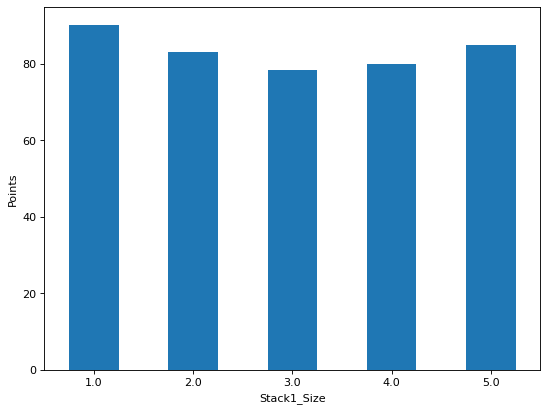

In [363]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
ax = stack1_size.plot.bar(x='lab', y='val', rot=0).set_ylabel('Points')